In [1]:
import os
import math
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
import seaborn as sns
import pandas as pd

plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# For GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

In [7]:
# Load and Preprocess the data
dataset_name = 'auto-mpg.data'
dataset_url = f'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/{dataset_name}'

!wget -qnc {dataset_url}

In [8]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

# Load the dataset into a Pandas data frame.
raw_dataset = pd.read_csv("./auto-mpg.data", names=column_names, na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
# Clean the data
dataset.isna().sum()

dataset.shape

# Use the dropna() method to remove data samples that are not fully populated.
dataset = dataset.dropna()
dataset.shape

dataset.isna().sum()

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


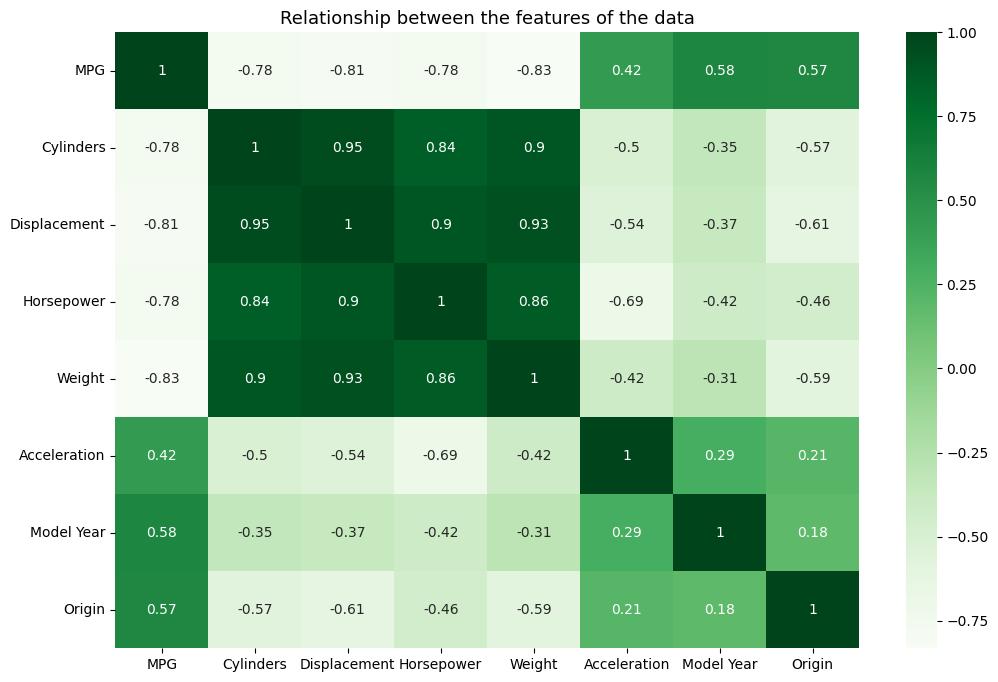

In [10]:
# Explore the dataset
plt.figure(figsize=(12,8))
sns.heatmap(dataset.corr(), cmap=plt.cm.Greens, annot=True)
plt.title('Relationship between the features of the data', fontsize=13)
plt.show()

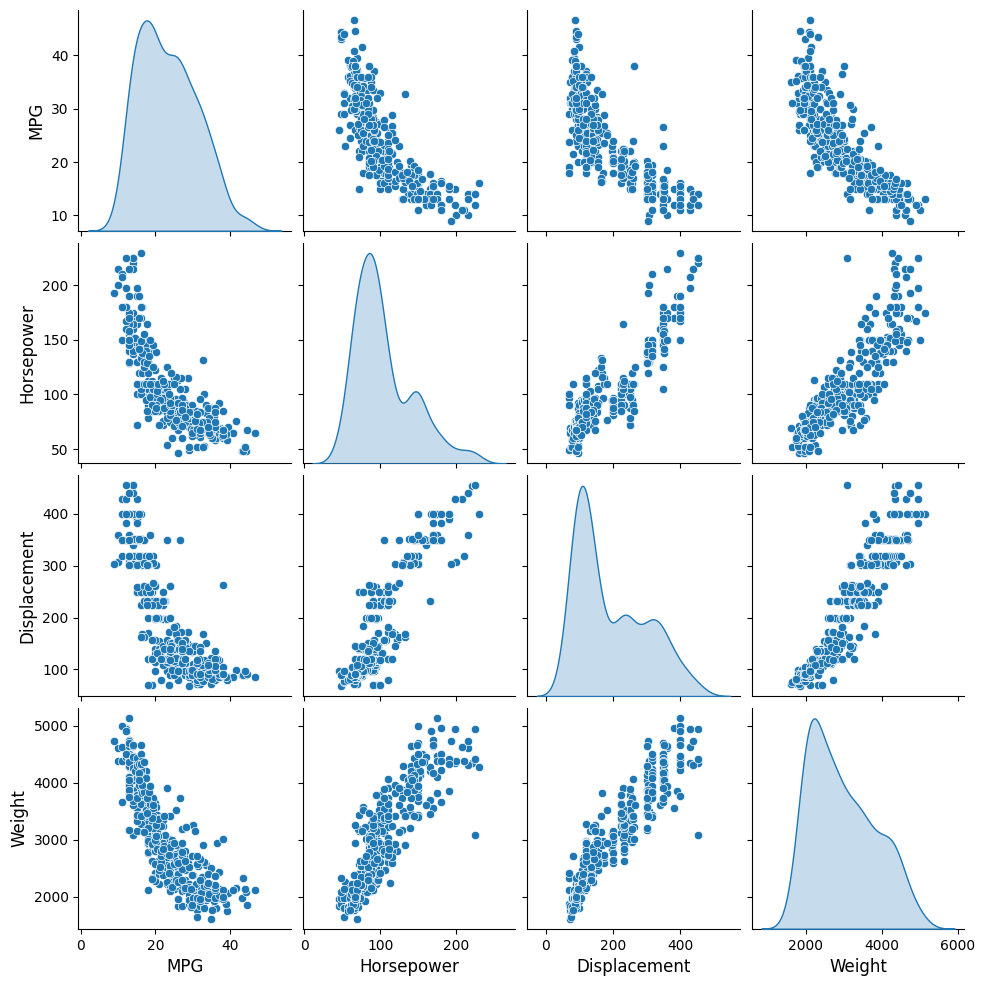

In [11]:
sns.pairplot(dataset[['MPG', 'Horsepower', 'Displacement', 'Weight']], diag_kind='kde');

In [12]:
# Train-Test split
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

train_dataset

(314, 8)
(78, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
79,26.0,4,96.0,69.0,2189.0,18.0,72,2
276,21.6,4,121.0,115.0,2795.0,15.7,78,2
248,36.1,4,91.0,60.0,1800.0,16.4,78,3
56,26.0,4,91.0,70.0,1955.0,20.5,71,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
...,...,...,...,...,...,...,...,...
218,36.0,4,79.0,58.0,1825.0,18.6,77,2
281,19.8,6,200.0,85.0,2990.0,18.2,79,1
342,30.0,4,135.0,84.0,2385.0,12.9,81,1
238,33.5,4,98.0,83.0,2075.0,15.9,77,1


In [13]:
# Check dataset stats
dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.445918,7.805007
Cylinders,5.471939,1.705783
Displacement,194.411990,104.644004
Horsepower,104.469388,38.491160
Weight,2977.584184,849.402560
Acceleration,15.541327,2.758864
Model Year,75.979592,3.683737
Origin,1.576531,0.805518


In [14]:
# Split features from target val
X_train = train_dataset.copy()
X_test  = test_dataset.copy()

# Separate target values from features.
y_train = X_train.pop('MPG')
y_test  = X_test.pop('MPG')

In [15]:
X_train_stats = X_train.describe().transpose()[['mean', 'std']]
X_train_stats

,mean,std
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
Origin,1.579618,0.808322


In [16]:
# Linear Regression

# Normalise Feature Data
# Convert the Horsepower feature in the dataframe to a NumPy array.
hp = np.array(X_train['Horsepower'])

# Create the normalization layer (for Horsepower).
hp_normalizer = layers.Normalization(input_shape=[1,], axis=None)

# Call the `adapt` method to apply the normalization.
hp_normalizer.adapt(hp)

print('Mean:  ', hp_normalizer.mean.numpy()[0])
print('Std:   ', math.sqrt(hp_normalizer.variance.numpy()[0]))
print('Count: ', hp_normalizer.count.numpy())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mean:   105.97134
Std:    39.573391877959644
Count:  0


In [17]:
# Create KERAS Model

# Instantiate the model.
linear_1d_model = tf.keras.Sequential()

# Add the normalization layer.
linear_1d_model.add(hp_normalizer)

# Add the single neuron.
linear_1d_model.add(Dense(1, input_shape=(1,)))

# Display the model summary.
linear_1d_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [18]:
linear_1d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae')

In [19]:
history_linear_1d = linear_1d_model.fit(
    X_train['Horsepower'],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

In [20]:
hist = pd.DataFrame(history_linear_1d.history)
hist.tail()

,loss,val_loss
95,3.782379,3.853483
96,3.781649,3.854790
97,3.782704,3.852968
98,3.782069,3.852753
99,3.781771,3.853589


In [21]:
def plot_loss(history):
    plt.figure(figsize=(15,5))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

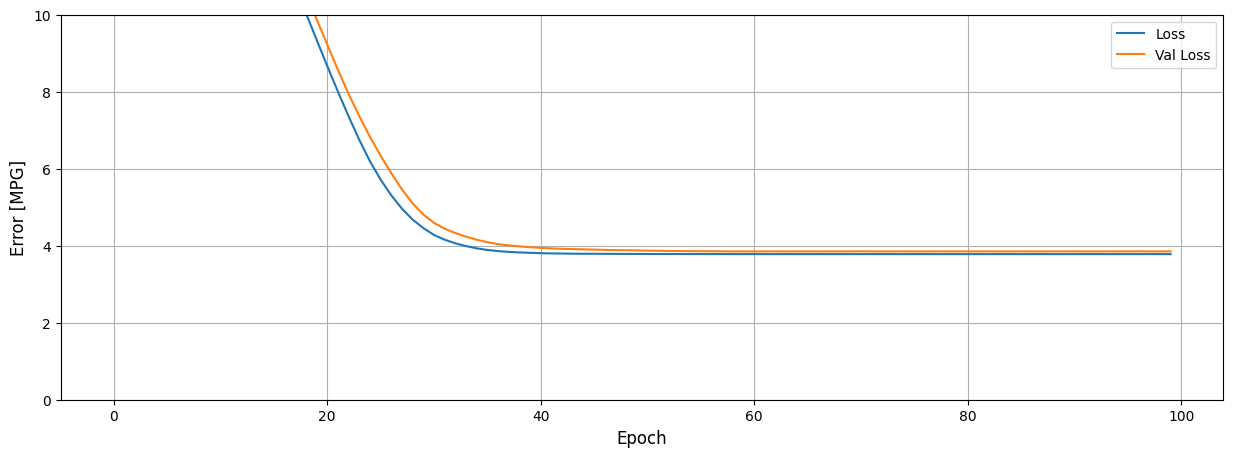

In [22]:
plot_loss(history_linear_1d)

In [23]:
# Model Prediction

# Generate feature data for Horsepower.
x = tf.linspace(0.0, 250, 251)

# Use the model to predict MPG.
y = linear_1d_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [24]:
def plot_horsepower(x, y):
    plt.figure(figsize=(15,5))
    plt.scatter(X_train['Horsepower'], y_train, label='Data', color='green', alpha=0.5)
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.grid(True)
    plt.legend()

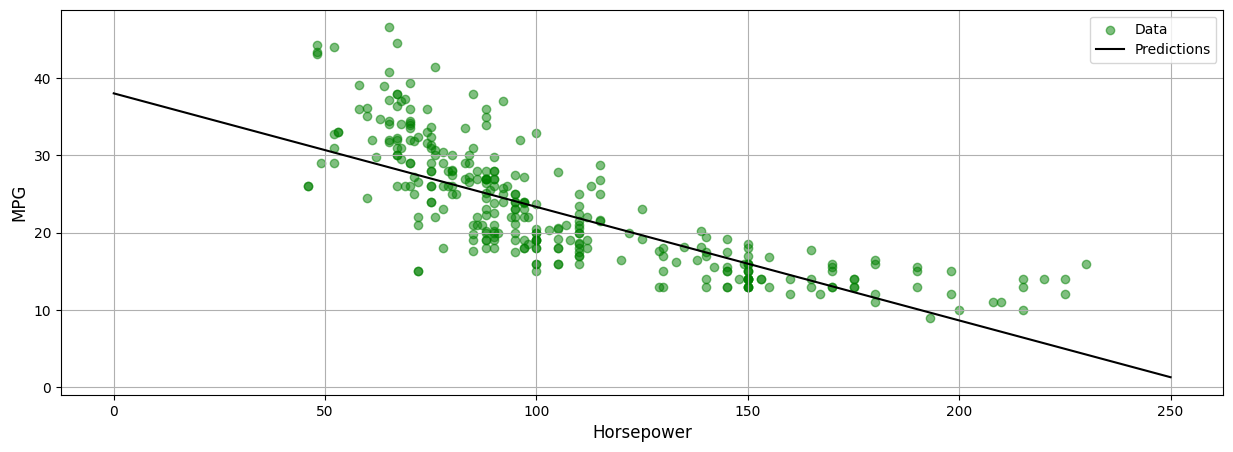

In [25]:
plot_horsepower(x,y)

In [26]:
# Non-trainable parameters.
mean     = linear_1d_model.layers[0].get_weights()[0]
variance = linear_1d_model.layers[0].get_weights()[1]
num_pts  = linear_1d_model.layers[0].get_weights()[2]
print('Horsepower Mean:  ', int(mean*1000)/1000)
print('Horsepower Std:   ', int(math.sqrt(variance)*1000)/1000)
print('Horsepower Pts:   ', num_pts)

Horsepower Mean:   105.971
Horsepower Std:    39.573
Horsepower Pts:    0


In [27]:
# Normalized weights.
slope_norm = linear_1d_model.layers[1].get_weights()[0]
y_int_norm = linear_1d_model.layers[1].get_weights()[1]

# Model parameters.
slope = slope_norm / math.sqrt(variance)
y_int = y_int_norm - mean*slope
print('Model Slope: ', slope[0][0])
print('Model Y-Int: ', y_int[0][0])

Model Slope:  -0.14704567
Model Y-Int:  38.035217


In [28]:
# Multivarient Linear Regression

# Normalization Layer
hp_dp = np.array(X_train[['Horsepower', 'Displacement']])
print(hp_dp.shape)

# Set 'axis' to be the axis of the feature dimension. Since the input shape is (num_points, 2), we need to set
# axis=1 to indicate that each feature should be normalized. Setting axis=-1 would also work in this case
# since a -1 indicates the last axis.
hp_dp_normalizer = layers.Normalization(input_shape=[2,], axis=1)
hp_dp_normalizer.adapt(hp_dp)

mean = hp_dp_normalizer.mean.numpy()
var = hp_dp_normalizer.variance.numpy()

std_1 = int(math.sqrt(var[0][0])*1000)/1000
std_2 = int(math.sqrt(var[0][1])*1000)/1000

print('Mean:  ', mean[0][0], mean[0][1])
print('Std:   ', std_1, std_2)
print('Count: ', hp_dp_normalizer.count.numpy())

(314, 2)
Mean:   105.97134 197.8551
Std:    39.573 106.332
Count:  0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Build Keras model
linear_2d_model = tf.keras.Sequential()
linear_2d_model.add(hp_dp_normalizer)
linear_2d_model.add(Dense(1, input_shape=(2,), activation=None))

linear_2d_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

In [30]:
linear_2d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae')

In [31]:
history_linear_2d = linear_2d_model.fit(
    X_train[['Horsepower', 'Displacement']],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

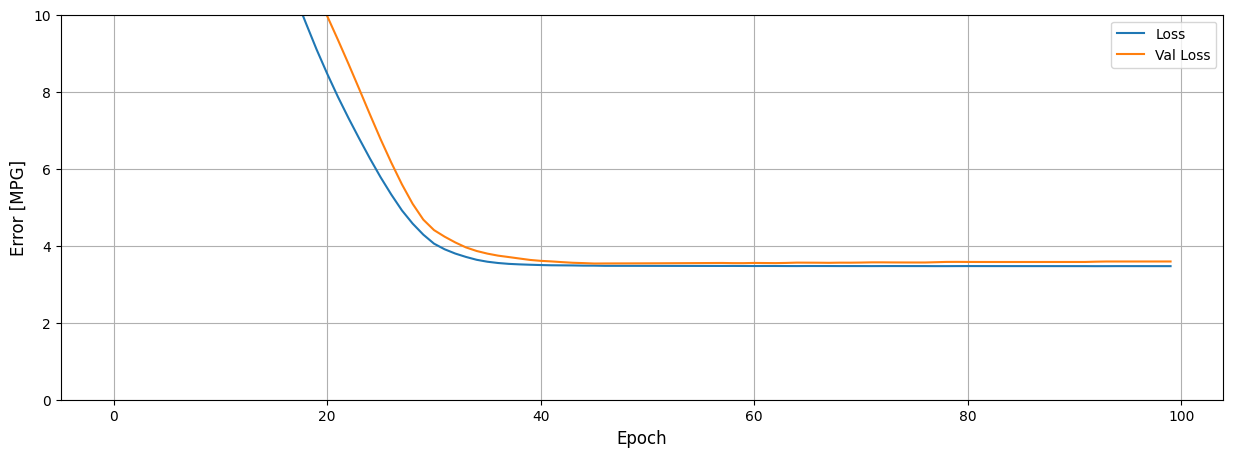

In [32]:
plot_loss(history_linear_2d)

In [33]:
# Visualize the Fitted Model
hp_min = X_train.Horsepower.min()
hp_max = X_train.Horsepower.max()
dp_min = X_train.Displacement.min()
dp_max = X_train.Displacement.max()

x_surf, y_surf = np.meshgrid(np.linspace(hp_min, hp_max, 100), np.linspace(dp_min, dp_max, 100))
x_grid = pd.DataFrame({'Horsepower': x_surf.ravel(), 'Displacement': y_surf.ravel()})

pred_y = linear_2d_model.predict(x_grid)
pred_y = np.array(pred_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


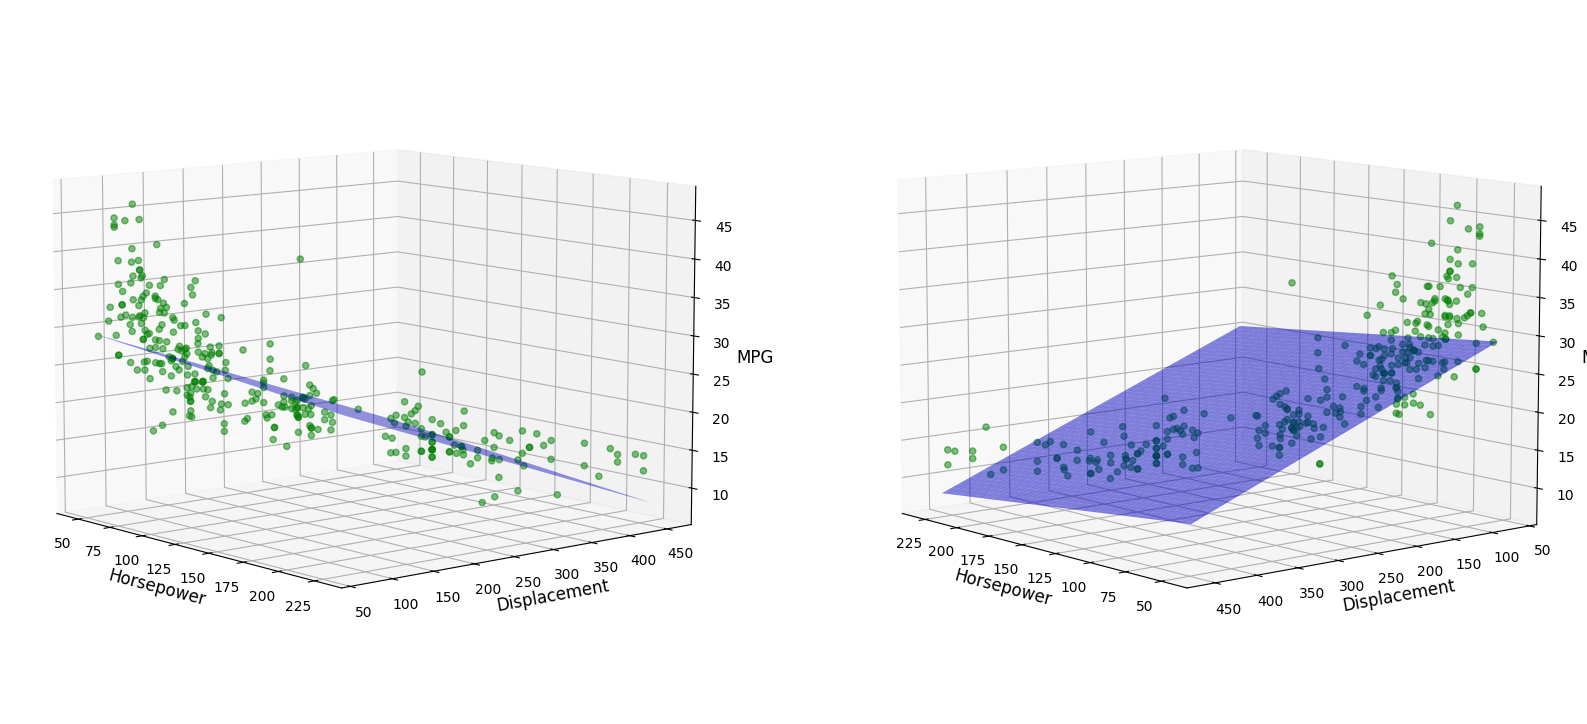

In [34]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green',  marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(9, -40)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(9, 140)

In [35]:
# Deep Learning with Single Feature

# Build the model in Keras.
dnn_1d_model = tf.keras.Sequential()
dnn_1d_model.add(hp_normalizer)                 # Previoulsy defined.
dnn_1d_model.add(Dense(32, activation='relu'))
dnn_1d_model.add(Dense(32, activation='relu'))
dnn_1d_model.add(Dense(1, activation=None))
dnn_1d_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156 (4.52 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 3 (16.00 B)

In [36]:
hidden_1 = dnn_1d_model.layers[1]
weights, biases = hidden_1.get_weights()
print(weights)
print('\n')
print(biases)

[[-0.08986446  0.20559436  0.32649338  0.15399665  0.02743787  0.39304143
   0.281067    0.3452382  -0.26232523  0.13287175 -0.27481106  0.07449114
   0.30436927  0.08021075  0.08599561  0.4038766   0.23611176  0.11563224
  -0.20238023  0.01358306 -0.02609441  0.1953308  -0.23583668  0.2764783
  -0.40524882 -0.1149703   0.17887688 -0.28214657 -0.08428189 -0.2017488
   0.34980398  0.01729169]]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
dnn_1d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mae')

In [38]:
history_dnn_1d = dnn_1d_model.fit(
    X_train['Horsepower'],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

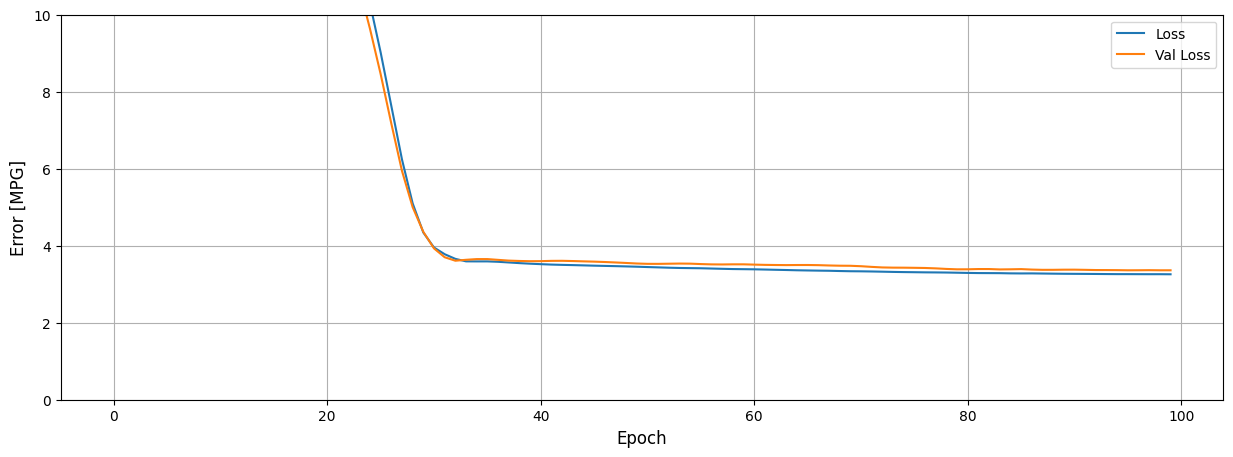

In [39]:
plot_loss(history_dnn_1d)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


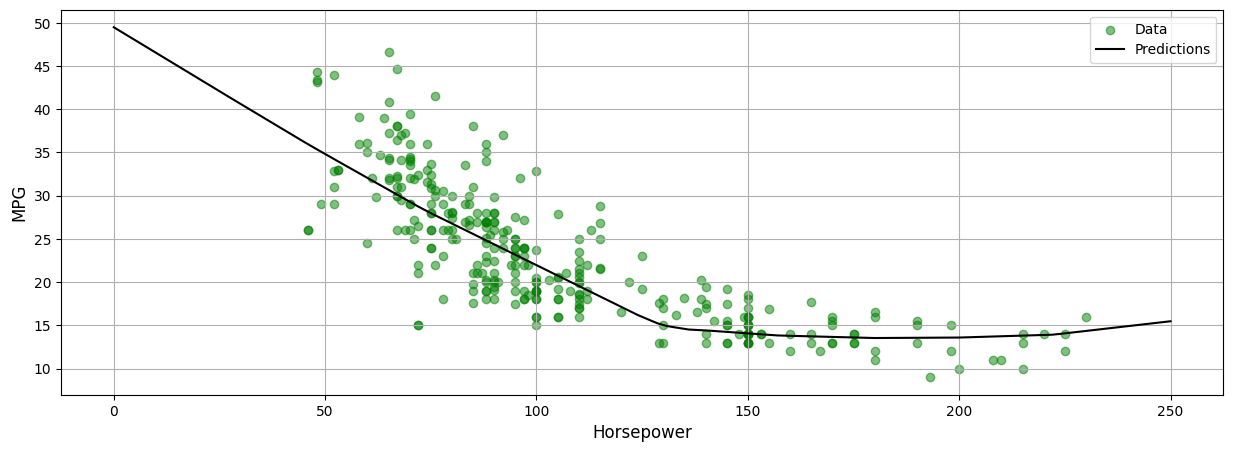

In [40]:
# Visualize the Fitted Model
x = tf.linspace(0.0, 250, 251)
y = dnn_1d_model.predict(x)

plot_horsepower(x, y)

In [41]:
dnn_2d_model = tf.keras.Sequential()
dnn_2d_model.add(hp_dp_normalizer)                # Previously defined.
dnn_2d_model.add(Dense(32, activation='relu'))
dnn_2d_model.add(Dense(32, activation='relu'))
dnn_2d_model.add(Dense(1, activation=None))
dnn_2d_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,190 (4.65 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 5 (24.00 B)

In [42]:
dnn_2d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mae')

In [43]:
# Train the model
history_dnn_2d = dnn_2d_model.fit(
    X_train[['Horsepower', 'Displacement']],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

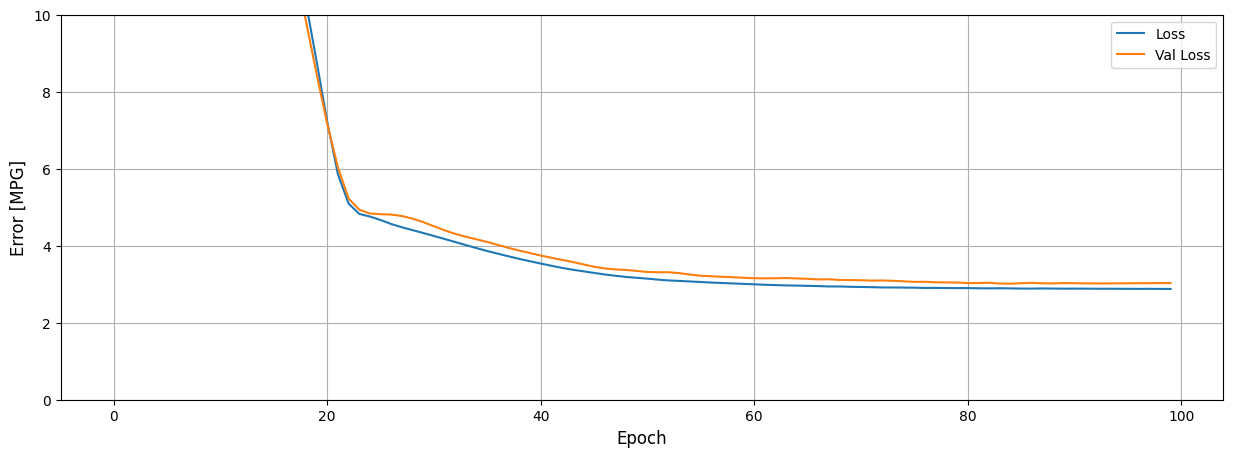

In [44]:
plot_loss(history_dnn_2d)

In [45]:
# Visualise the fitted model
hp_min = X_train.Horsepower.min()
hp_max = X_train.Horsepower.max()
dp_min = X_train.Displacement.min()
dp_max = X_train.Displacement.max()

x_surf, y_surf = np.meshgrid(np.linspace(hp_min, hp_max, 100), np.linspace(dp_min, dp_max, 100))
x_grid = pd.DataFrame({'Horsepower': x_surf.ravel(), 'Displacement': y_surf.ravel()})

pred_y = dnn_2d_model.predict(x_grid)
pred_y = np.array(pred_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


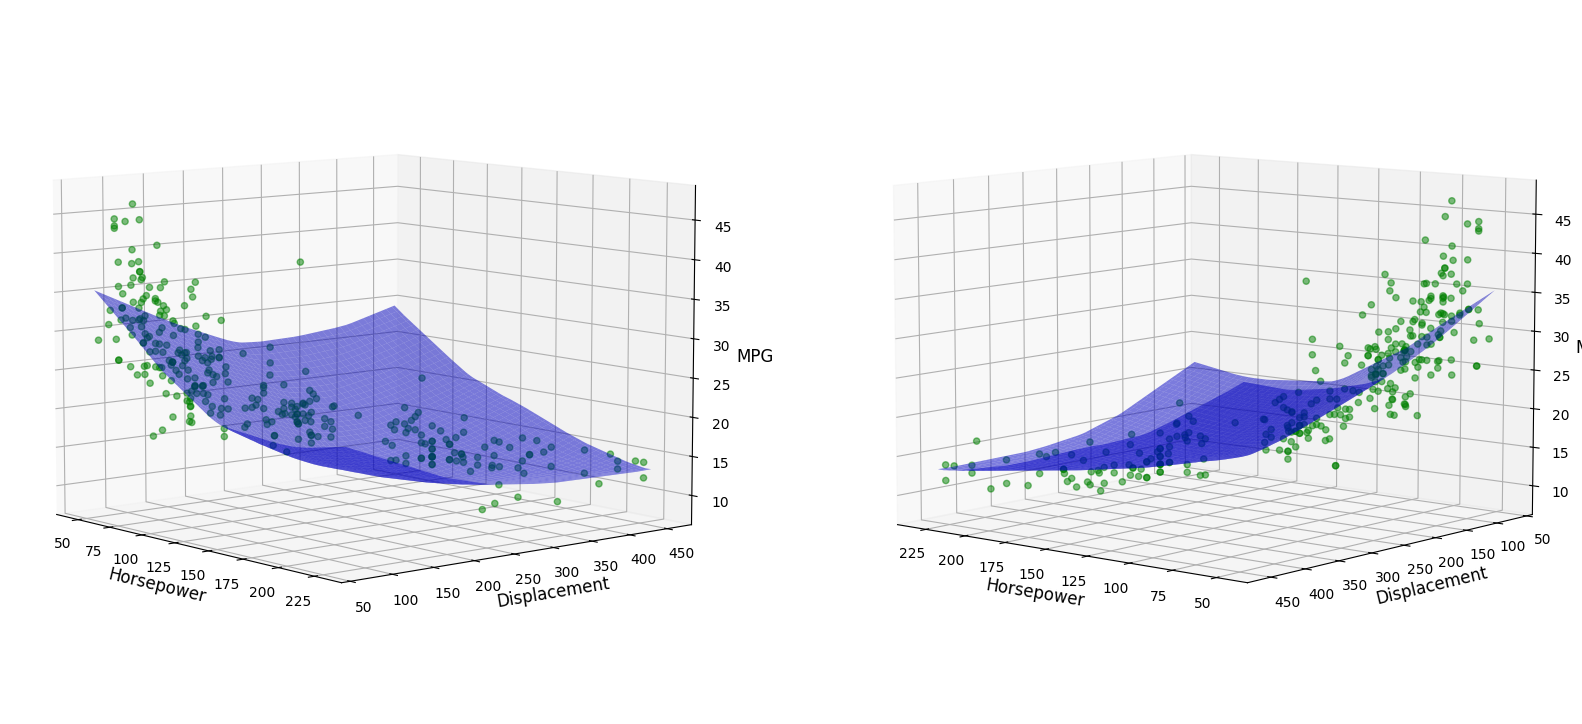

In [46]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green',  marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(8, -40)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(8, 130)

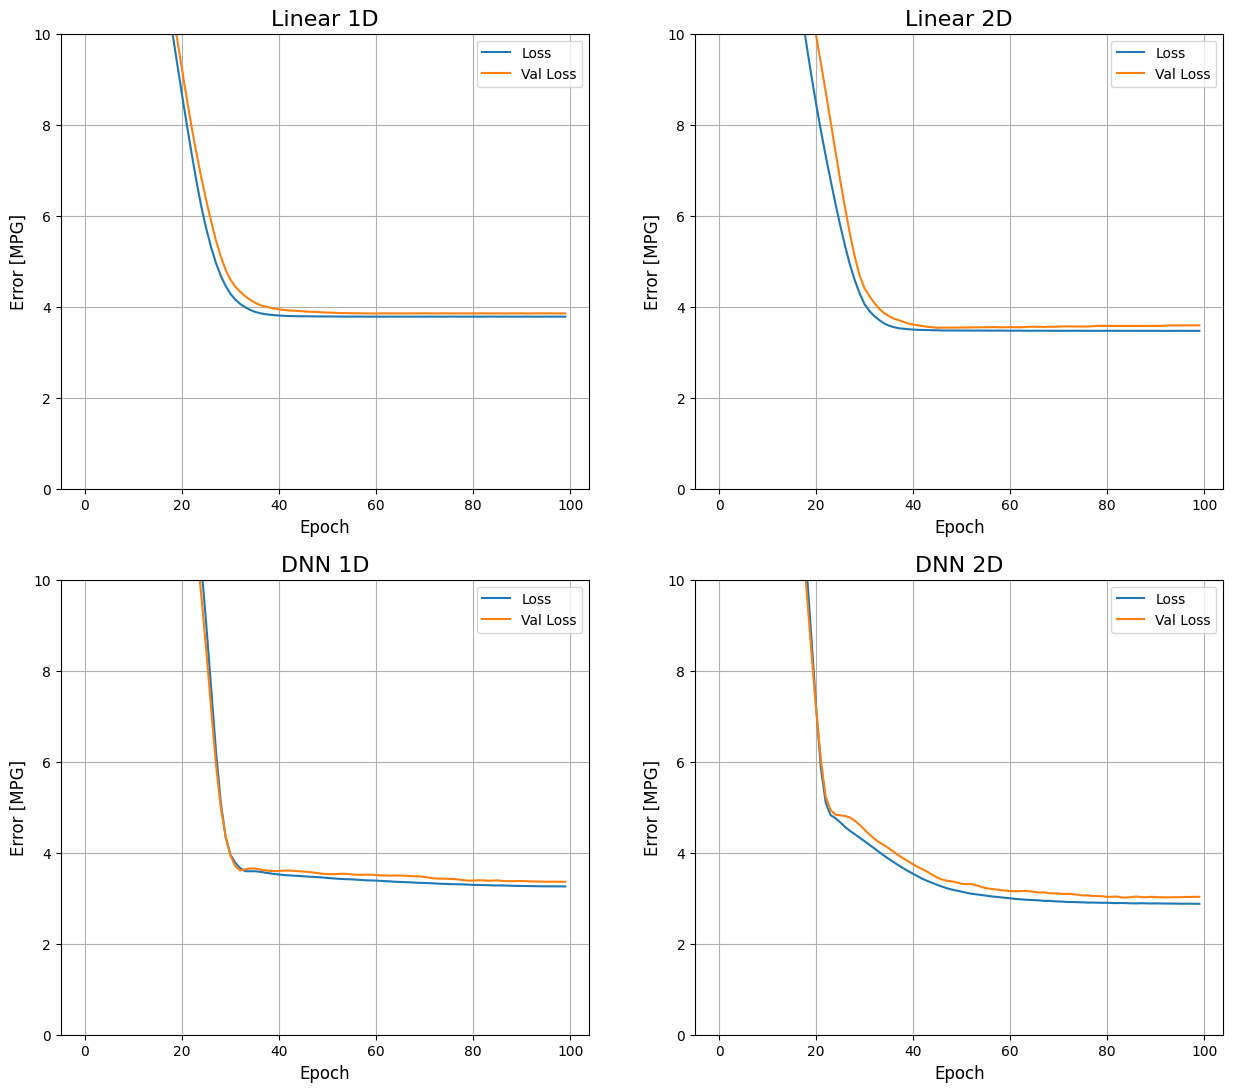

In [48]:
# Compare training loss curve
plt.figure(figsize=(15, 13))
plt.subplot(2,2,1)
plt.plot(history_linear_1d.history['loss'], label='Loss')
plt.plot(history_linear_1d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('Linear 1D')
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history_linear_2d.history['loss'], label='Loss')
plt.plot(history_linear_2d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('Linear 2D')
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history_dnn_1d.history['loss'], label='Loss')
plt.plot(history_dnn_1d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('DNN 1D')
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_dnn_2d.history['loss'], label='Loss')
plt.plot(history_dnn_2d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('DNN 2D')
plt.legend()
plt.grid(True)

In [49]:
# Model evaluation comparison
# Create a dictionary to store test results.
test_results = {}

# Linear regression test results.
test_results['linear_1d_model'] = linear_1d_model.evaluate(X_test['Horsepower'], y_test, verbose=0)
test_results['linear_2d_model'] = linear_2d_model.evaluate(X_test[['Horsepower', 'Displacement']],
                                                            y_test, verbose=0)
# Deep learning regression test results.
test_results['dnn_1d_model']    = dnn_1d_model.evaluate(X_test['Horsepower'], y_test, verbose=0)
test_results['dnn_2d_model']    = dnn_2d_model.evaluate(X_test[['Horsepower', 'Displacement']],
                                                            y_test, verbose=0)

In [50]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

,Mean Absolute Error [MPG]
linear_1d_model,4.015820
linear_2d_model,3.572306
dnn_1d_model,3.522017
dnn_2d_model,2.977174


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


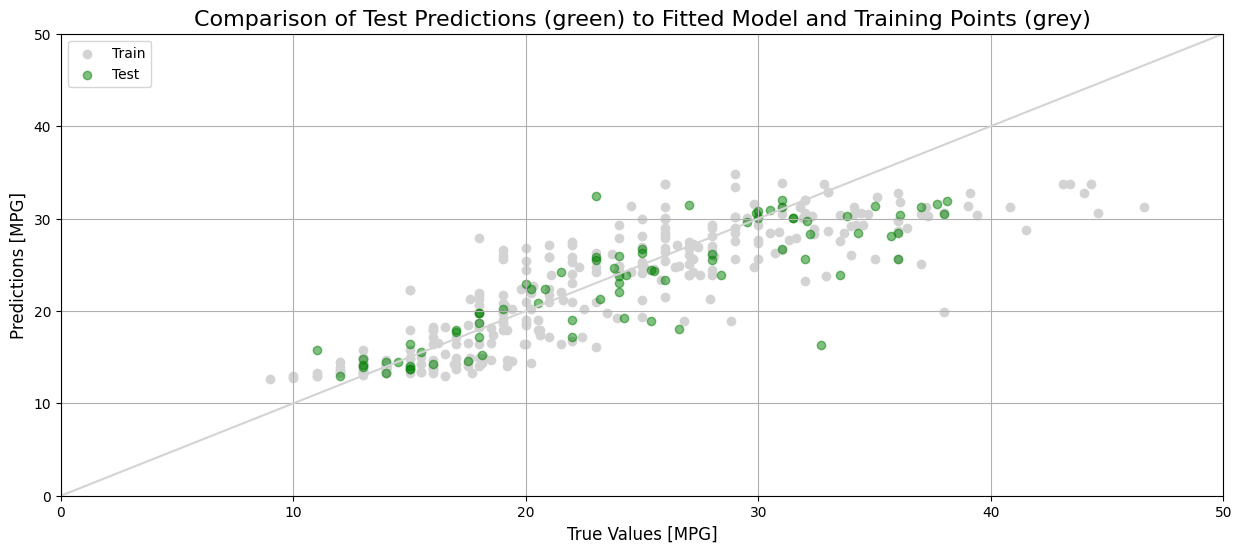

In [51]:
# Visualizing model predictions
train_predictions = dnn_2d_model.predict(X_train[['Horsepower', 'Displacement']]).flatten()
test_predictions = dnn_2d_model.predict(X_test[['Horsepower', 'Displacement']]).flatten()

plt.scatter(y_train, train_predictions, c='lightgray')
plt.scatter(y_test, test_predictions, c='green', alpha=.5)
plt.title('Comparison of Test Predictions (green) to Fitted Model and Training Points (grey)')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.legend(['Train', 'Test'])
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.grid('on')
plt.plot(lims, lims, c='lightgray');

In [52]:
test_error = test_predictions - y_test

mae = sum(abs(test_error))/len(y_test)
print('MAE for dnn_2d_model: ', int(mae*10000)/10000)

MAE for dnn_2d_model:  2.9771


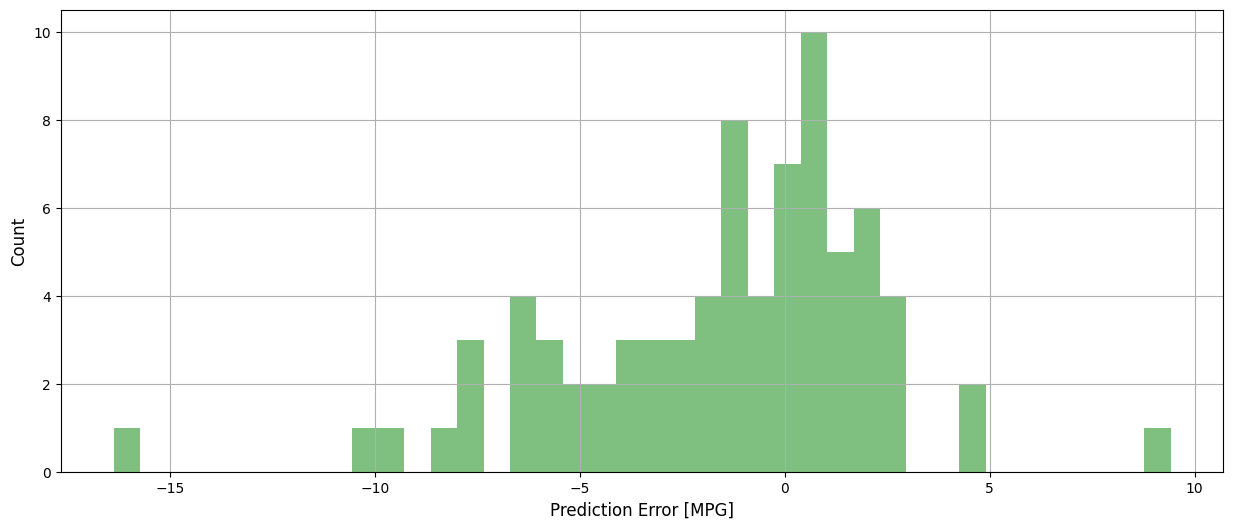

In [53]:
# Test Error Distribution
plt.hist(test_error, bins=40, color='green', alpha=.5)
plt.xlabel('Prediction Error [MPG]')
plt.grid('on')
plt.ylabel('Count');